# 평가 조건
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?
 - 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 만든 csv파일을 캐글 My submission까지 진행했고, submission 결과를 이미지로 제출하였다.
2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
 - 제출한 주피터노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
 - 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

# 모듈임포트

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 데이터 불러오기

In [2]:
os.getcwd()

'c:\\Users\\USER\\Desktop\\주피터파일\\aiffel\\exploration'

In [2]:
data_dir = 'c:/Users/USER/Desktop/주피터파일/aiffel/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


# 데이터 전처리 및 EDA

In [3]:
train.tail()

id             date      price  bedrooms  bathrooms  sqft_living  \
15030  15030  20141014T000000   610685.0         4       2.50         2520   
15031  15031  20150326T000000  1007500.0         4       3.50         3510   
15032  15032  20140521T000000   360000.0         3       2.50         1530   
15033  15033  20150223T000000   400000.0         4       2.50         2310   
15034  15034  20141015T000000   325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
15030      6023     2.0           0     0  ...      9        2520   
15031      7200     2.0           0     0  ...      9        2600   
15032      1131     3.0           0     0  ...      8        1530   
15033      5813     2.0           0     0  ...      8        2310   
15034      1076     2.0           0     0  ...      7        1020   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
15030              0      2014             0    98056  47.5137 -122.167   
15031            910      2009             0    98136  47.5537 -122.398   
15032              0      2009             0    98103  47.6993 -122.346   
15033              0      2014             0    98146  47.5107 -122.362   
15034              0      2008             0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
15030           2520        6023  
15031           2050        6200  
15032           1530        1509  
15033           1830        7200  
15034           1020        1357  

[5 rows x 21 columns]

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

# 데이터 전처리 및 EDA

In [4]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

None

## null값 확인 

In [5]:
display(train.isnull().sum())
display(test.isnull().sum())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 상관관계

In [6]:
train_corr = train.corr()
train_corr

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id             1.000000  0.020899  0.010520   0.104030     0.041725 -0.034077   
price          0.020899  1.000000  0.323672   0.525479     0.702899  0.096793   
bedrooms       0.010520  0.323672  1.000000   0.530548     0.596974  0.033475   
bathrooms      0.104030  0.525479  0.530548   1.000000     0.755853  0.089308   
sqft_living    0.041725  0.702899  0.596974   0.755853     1.000000  0.176500   
sqft_lot      -0.034077  0.096793  0.033475   0.089308     0.176500  1.000000   
floors         0.182848  0.262588  0.189532   0.508649     0.363193  0.001535   
waterfront    -0.011775  0.265738 -0.004819   0.075452     0.108137  0.025584   
view          -0.024360  0.400806  0.085703   0.187488     0.282821  0.080441   
condition     -0.101618  0.039740  0.034885  -0.125907    -0.054213 -0.002099   
grade          0.078622  0.667211  0.375286   0.666278     0.762543  0.119906   
sqft_above     0.073086  0.608577  0.494867   0.688255     0.878736  0.186242   
sqft_basement -0.050634  0.322218  0.315183   0.282642     0.434017  0.017818   
yr_built       0.202477  0.047290  0.158799   0.503964     0.315927  0.058686   
yr_renovated  -0.029810  0.140808  0.022729   0.065423     0.064893 -0.001451   
zipcode       -0.005761 -0.051498 -0.162081  -0.207500    -0.200745 -0.127709   
lat            0.002588  0.301604 -0.011190   0.018110     0.051609 -0.082234   
long           0.014757  0.023547  0.135802   0.227669     0.245429  0.227451   
sqft_living15  0.029248  0.586419  0.407394   0.573541     0.760271  0.147562   
sqft_lot15    -0.032269  0.086384  0.027242   0.088120     0.184176  0.728458   

                 floors  waterfront      view  condition     grade  \
id             0.182848   -0.011775 -0.024360  -0.101618  0.078622   
price          0.262588    0.265738  0.400806   0.039740  0.667211   
bedrooms       0.189532   -0.004819  0.085703   0.034885  0.375286   
bathrooms      0.508649    0.075452  0.187488  -0.125907  0.666278   
sqft_living    0.363193    0.108137  0.282821  -0.054213  0.762543   
sqft_lot       0.001535    0.025584  0.080441  -0.002099  0.119906   
floors         1.000000    0.031159  0.034511  -0.261016  0.462598   
waterfront     0.031159    1.000000  0.389669   0.011613  0.088061   
view           0.034511    0.389669  1.000000   0.045255  0.247924   
condition     -0.261016    0.011613  0.045255   1.000000 -0.143599   
grade          0.462598    0.088061  0.247924  -0.143599  1.000000   
sqft_above     0.529476    0.081968  0.172693  -0.152856  0.759240   
sqft_basement -0.239350    0.071576  0.265880   0.175064  0.162657   
yr_built       0.490436   -0.026523 -0.061670  -0.366590  0.440608   
yr_renovated   0.009752    0.104168  0.107605  -0.062342  0.030155   
zipcode       -0.059107    0.028632  0.089247   0.001106 -0.186541   
lat            0.049004   -0.014772  0.005285  -0.015974  0.112319   
long           0.126983   -0.037922 -0.073151  -0.110742  0.202130   
sqft_living15  0.287125    0.091810  0.278267  -0.091407  0.715321   
sqft_lot15    -0.010287    0.028255  0.076501  -0.003873  0.119734   

               sqft_above  sqft_basement  yr_built  yr_renovated   zipcode  \
id               0.073086      -0.050634  0.202477     -0.029810 -0.005761   
price            0.608577       0.322218  0.047290      0.140808 -0.051498   
bedrooms         0.494867       0.315183  0.158799      0.022729 -0.162081   
bathrooms        0.688255       0.282642  0.503964      0.065423 -0.207500   
sqft_living      0.878736       0.434017  0.315927      0.064893 -0.200745   
sqft_lot         0.186242       0.017818  0.058686     -0.001451 -0.127709   
floors           0.529476      -0.239350  0.490436      0.009752 -0.059107   
waterfront       0.081968       0.071576 -0.026523      0.104168  0.028632   
view             0.172693       0.265880 -0.061670      0.107605  0.089247   
condition       -0.152856       0.175064 -0.366590     -0.062342  0.

<Axes: >

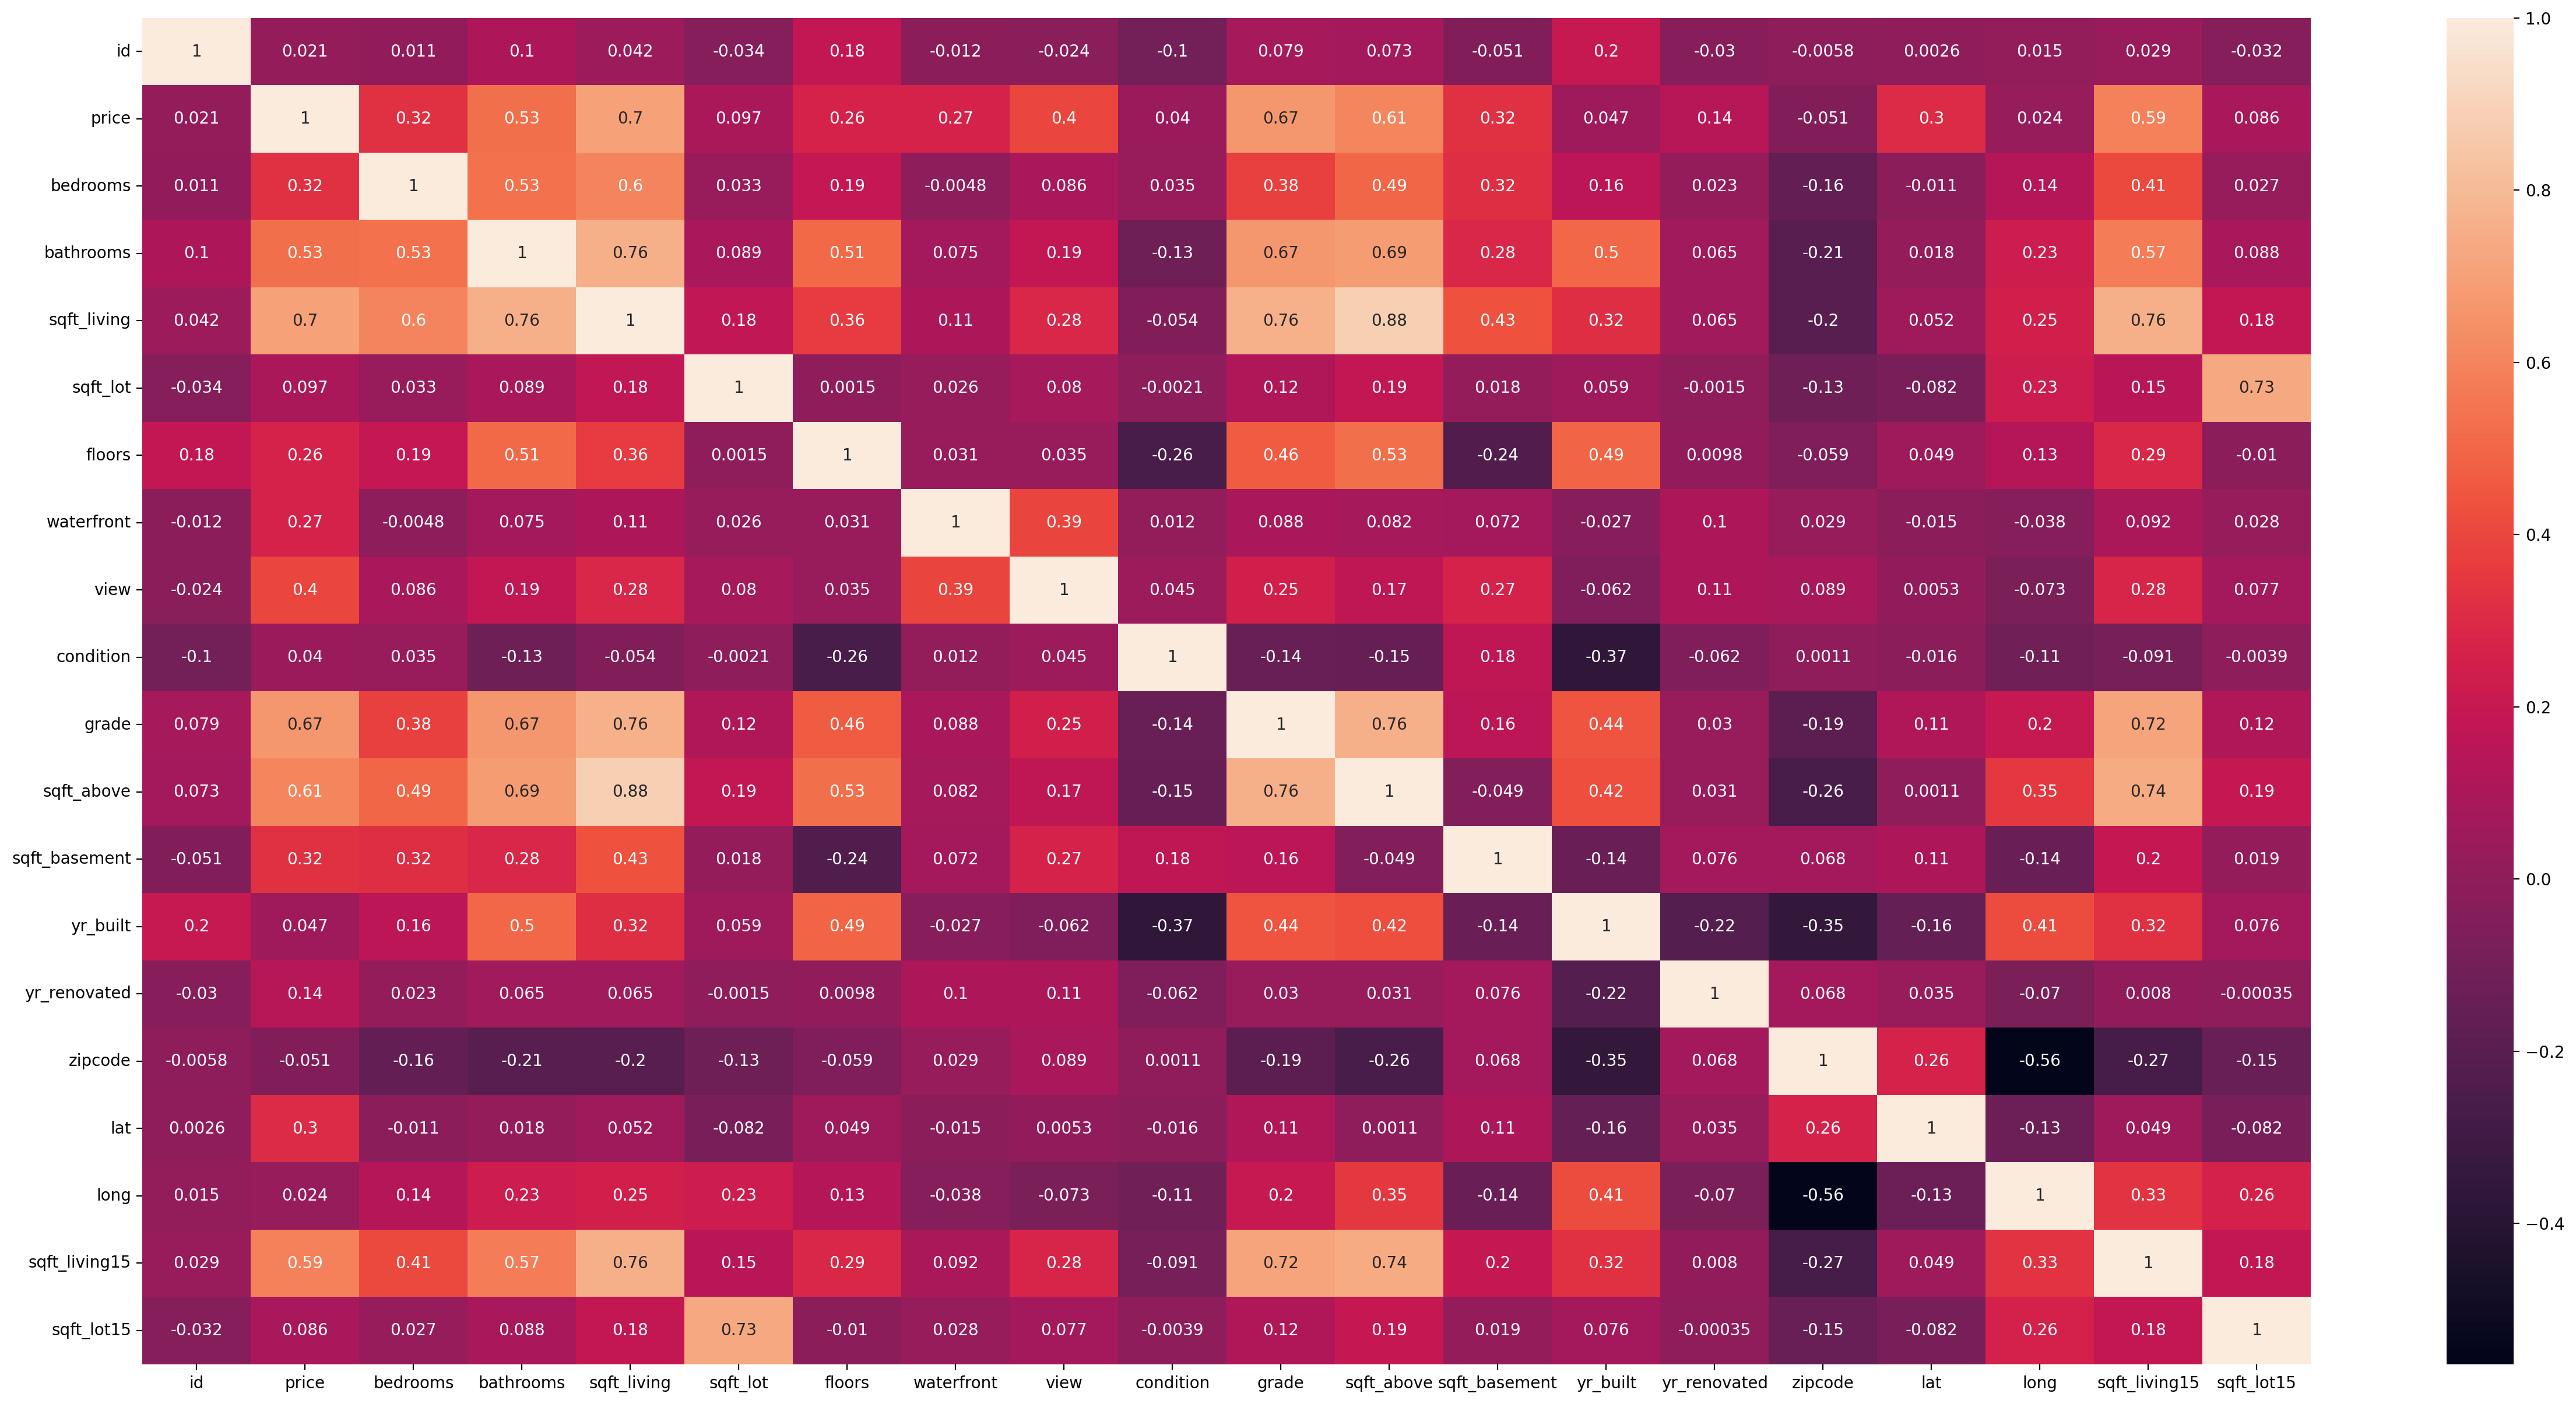

In [7]:
plt.figure(figsize=(30,15))
sns.heatmap(train.corr(), annot=True)

- date 변수 정수형으로 타입으로 바꾸고 형식 변환

In [8]:
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)
test['date'] = test['date'].apply(lambda x : str(x[:6])).astype(int)

train.tail()

id    date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
15030  15030  201410   610685.0         4       2.50         2520      6023   
15031  15031  201503  1007500.0         4       3.50         3510      7200   
15032  15032  201405   360000.0         3       2.50         1530      1131   
15033  15033  201502   400000.0         4       2.50         2310      5813   
15034  15034  201410   325000.0         2       0.75         1020      1076   

       floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
15030     2.0           0     0  ...      9        2520              0   
15031     2.0           0     0  ...      9        2600            910   
15032     3.0           0     0  ...      8        1530              0   
15033     2.0           0     0  ...      8        2310              0   
15034     2.0           0     0  ...      7        1020              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
15030      2014             0    98056  47.5137 -122.167           2520   
15031      2009             0    98136  47.5537 -122.398           2050   
15032      2009             0    98103  47.6993 -122.346           1530   
15033      2014             0    98146  47.5107 -122.362           1830   
15034      2008             0    98144  47.5941 -122.299           1020   

       sqft_lot15  
15030        6023  
15031        6200  
15032        1509  
15033        7200  
15034        1357  

[5 rows x 21 columns]

## 데이터 시각화
### RegPlot
- RegPlot은 Regression Plot의 약자
- 데이터의 분포와, 이 데이터를 선형으로 표현하는 Regression Line을 동시에 표현해주는 그래프

In [9]:
cols = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode','lat', 'long', 'sqft_living15', 'sqft_lot15']

len(cols)

18

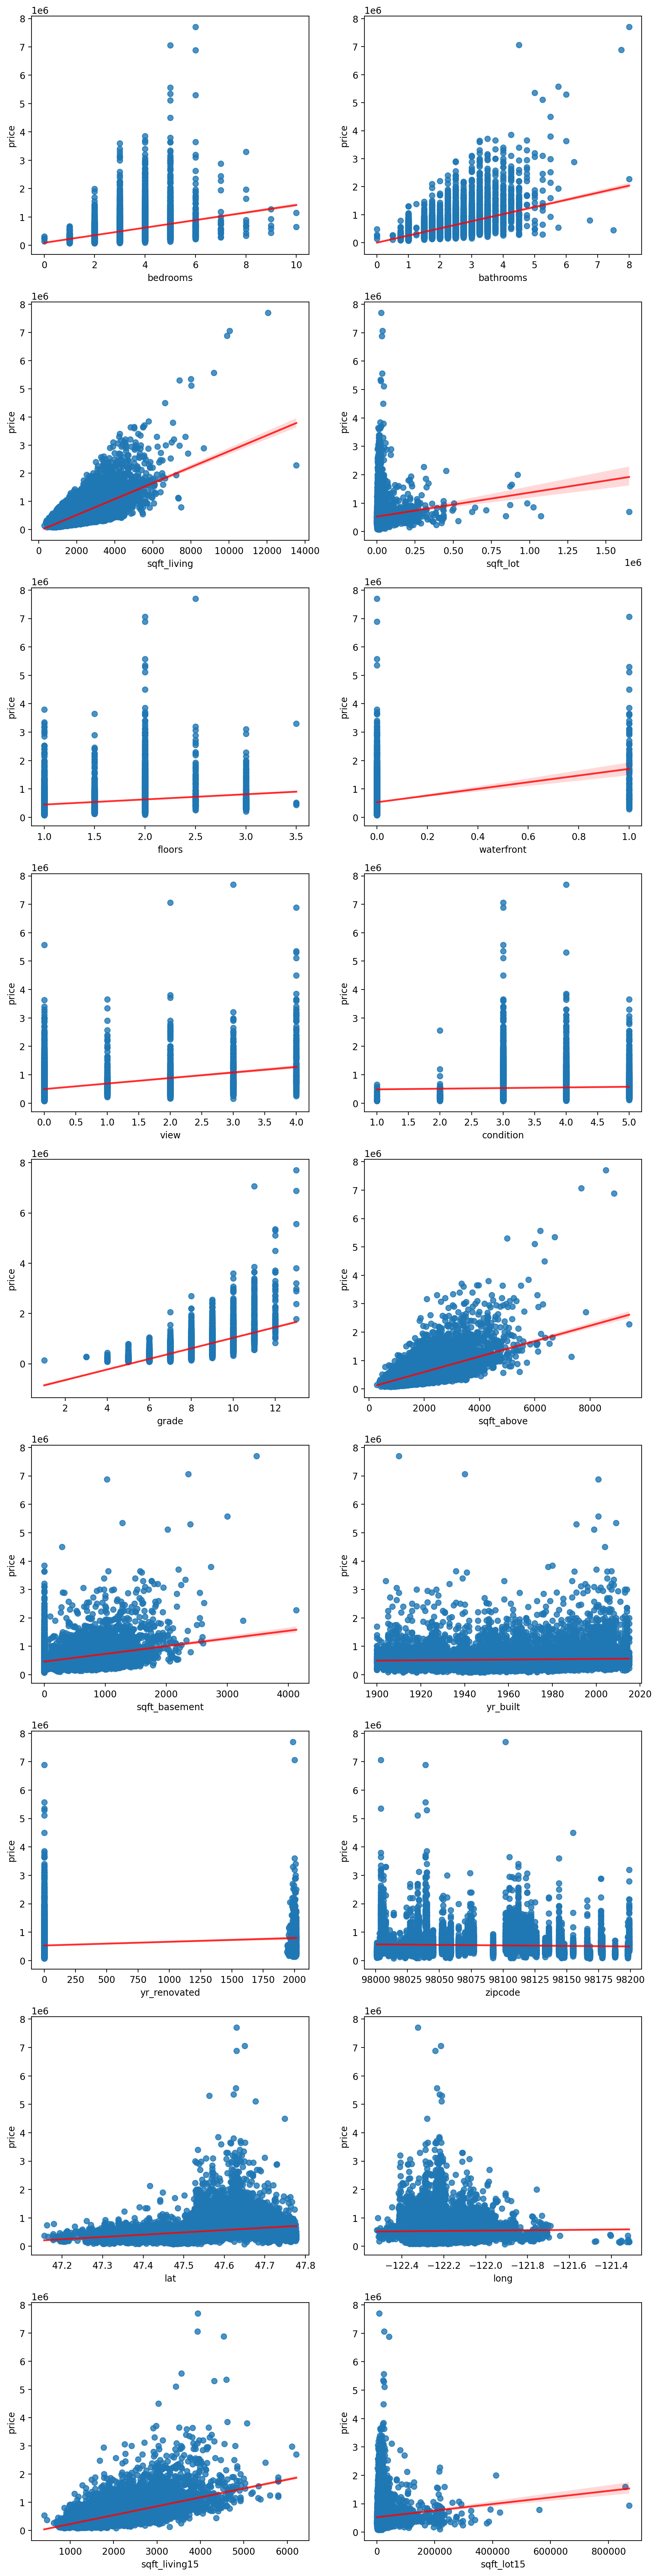

In [10]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   

count = 0
# columns = data.columns
for row in range(9):
    for col in range(2):
        sns.regplot(x = cols[count], y = "price", data = train, ax = ax[row,col],
                   line_kws={"color":"r","alpha":0.8,'lw':2} ) #선형 라인에 대한 것
        count += 1


### histoplot

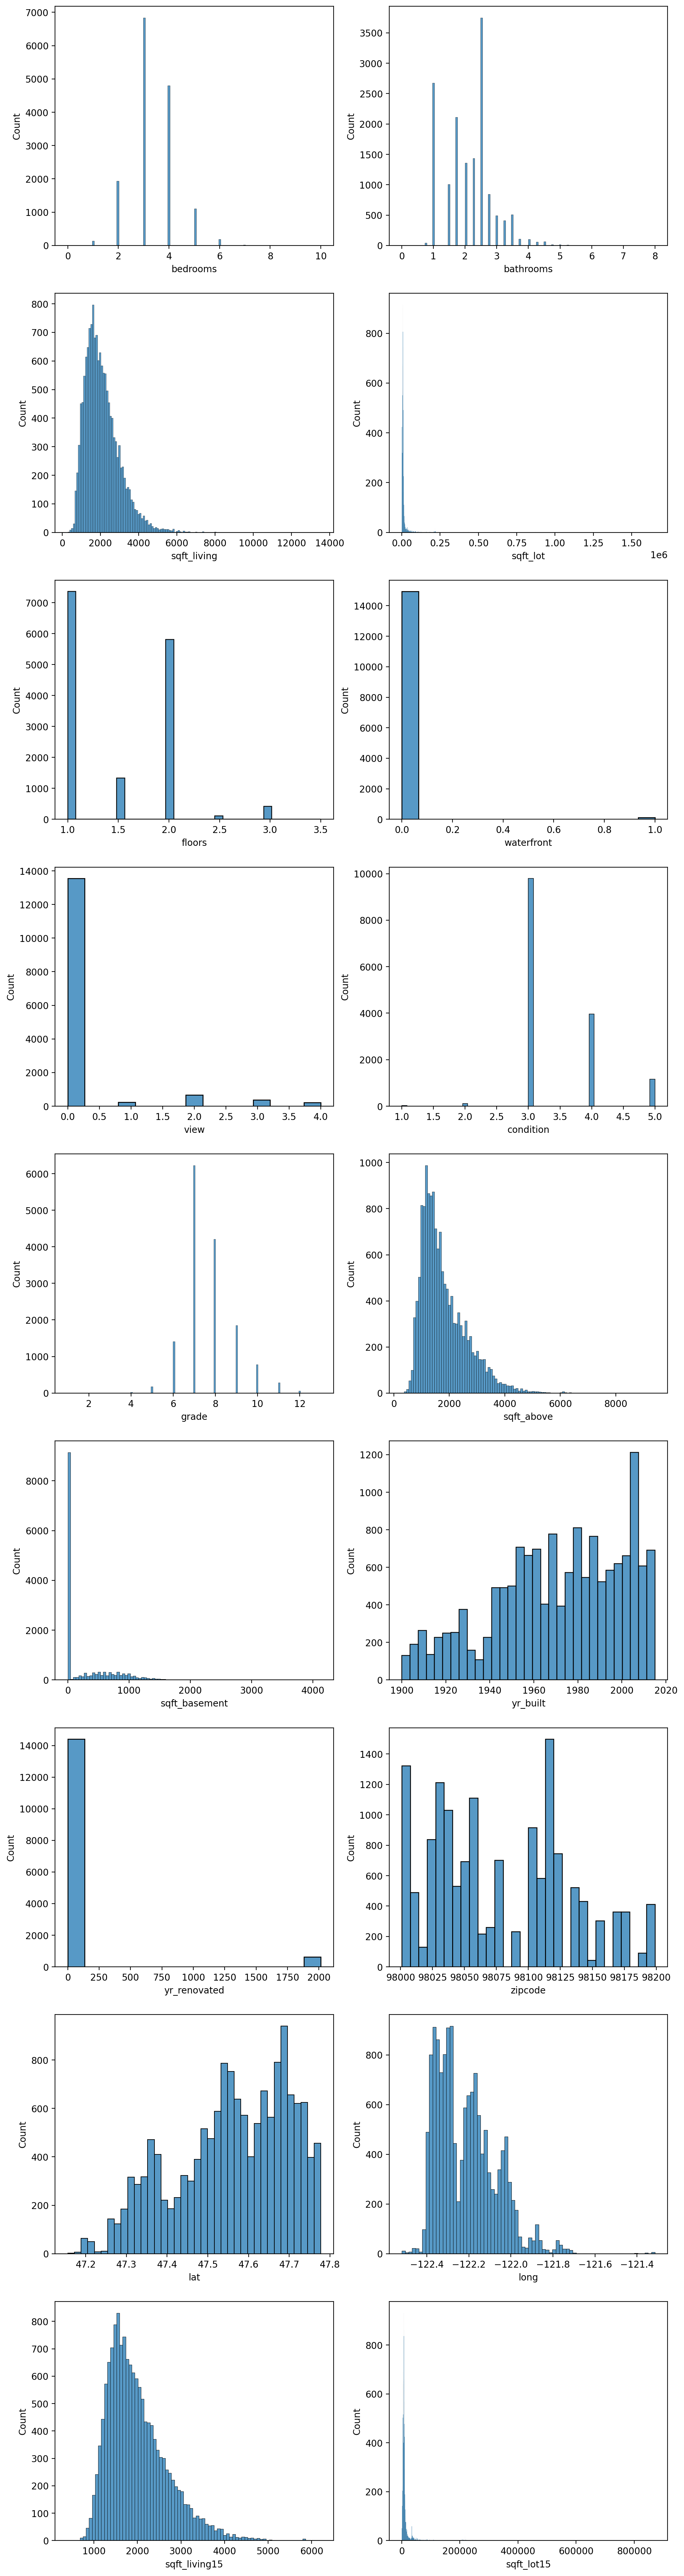

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   

count = 0
# columns = data.columns
for row in range(9):
    for col in range(2):
        sns.histplot(x = cols[count], data = train, ax = ax[row,col])
        count += 1


- yr_renovated 변수는 재건축년도를 나타내는데 다양한 년도값들이 존재함
- 해당 변수를 재건축을 했으면 1, 안했으면 0으로 바꿔주기

In [12]:
for i in range(len(train['yr_renovated'])):
    if train['yr_renovated'][i] != 0:
        train['yr_renovated'][i] = 1
        
train['yr_renovated'].value_counts()

0    14404
1      631
Name: yr_renovated, dtype: int64

In [13]:
for i in range(len(test['yr_renovated'])):
    if test['yr_renovated'][i] != 0:
        test['yr_renovated'][i] = 1
        
test['yr_renovated'].value_counts()

0    6186
1     282
Name: yr_renovated, dtype: int64

- view 변수도 다양한 값들이 존재
- 하지만 0이 많고, 나머지는 적기 때문에 0 아니면 1로 바꿔주기

In [14]:
for i in range(len(train['view'])):
    if train['view'][i] != 0:
        train['view'][i] = 1
        
train['view'].value_counts()

0    13548
1     1487
Name: view, dtype: int64

In [15]:
for i in range(len(test['view'])):
    if test['view'][i] != 0:
        test['view'][i] = 1
        
test['view'].value_counts()

0    5837
1     631
Name: view, dtype: int64

In [16]:
#타겟변수 따로 빼주기

y = train['price']
del train['price']

## 로그변환
- price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_lot15', sqft_living15 변수는 왜도가 치우쳐져 있어서 로그 변환을 진행

In [17]:
train_len = len(train)
data = pd.concat([train, test], axis = 0)

print(len(data))

21503


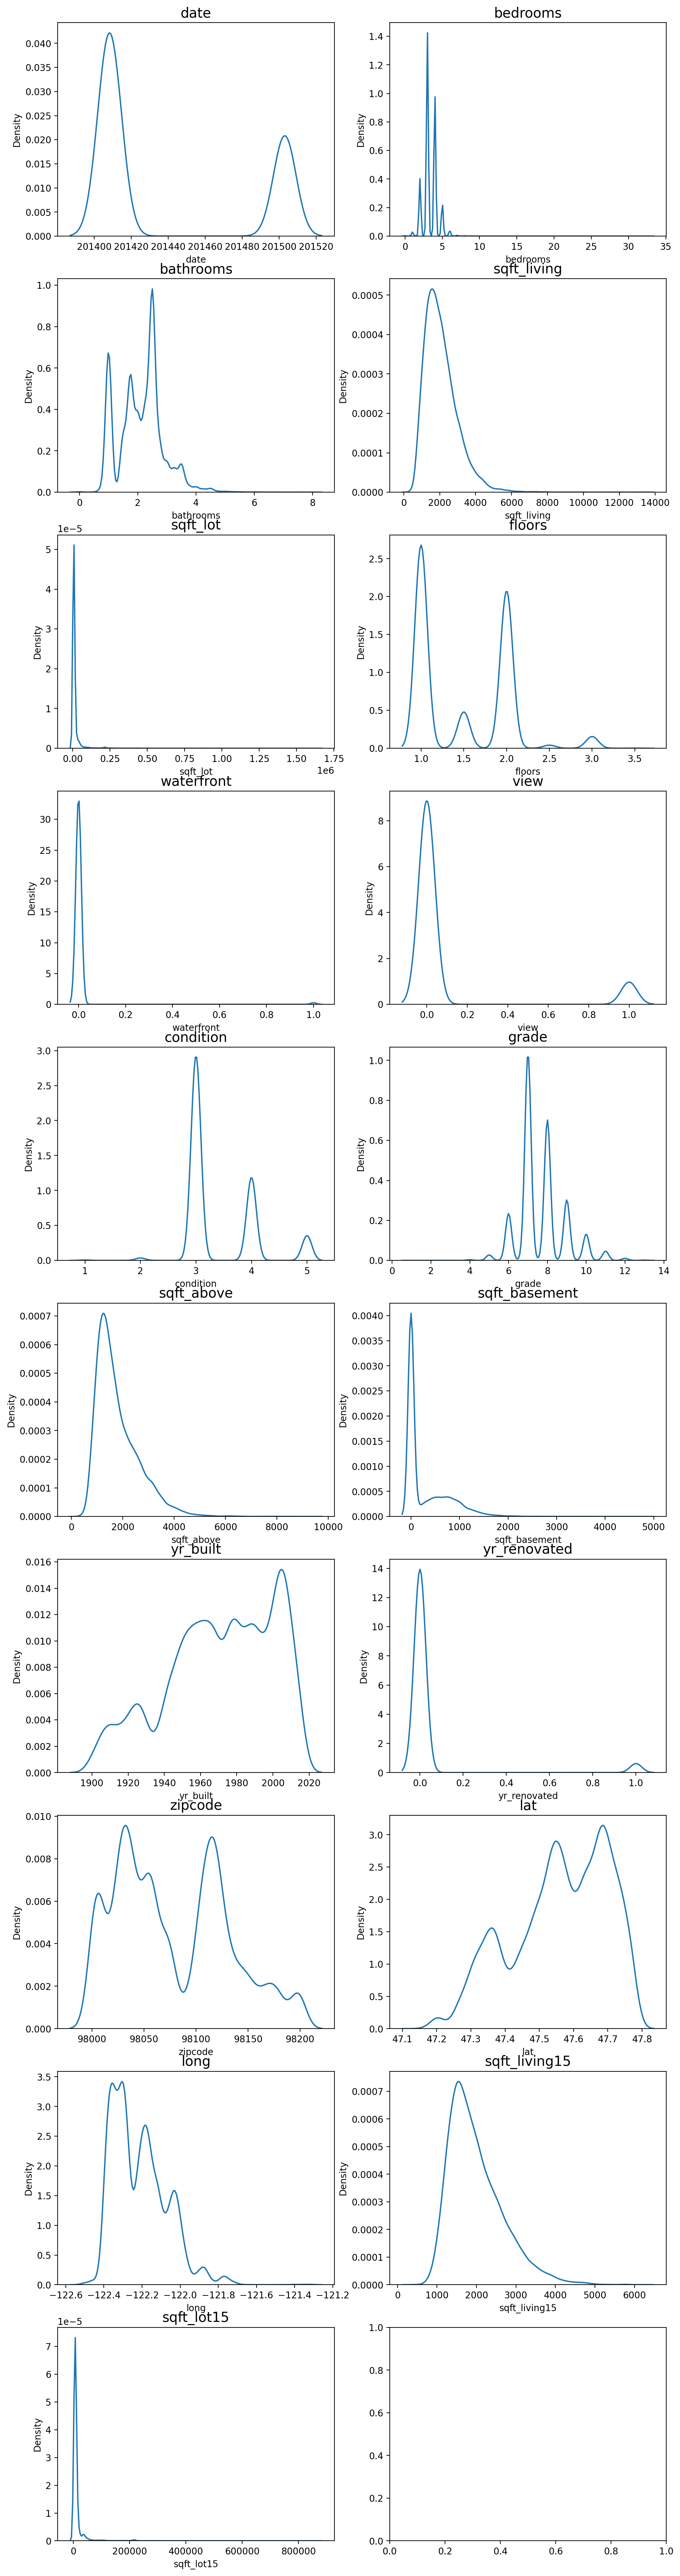

In [18]:
fig, ax = plt.subplots(10, 2, figsize=(12, 50))   

count = 1
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 20:
            break

In [19]:
logs_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for i in logs_columns:
    data[i] = np.log1p(data[i].values)

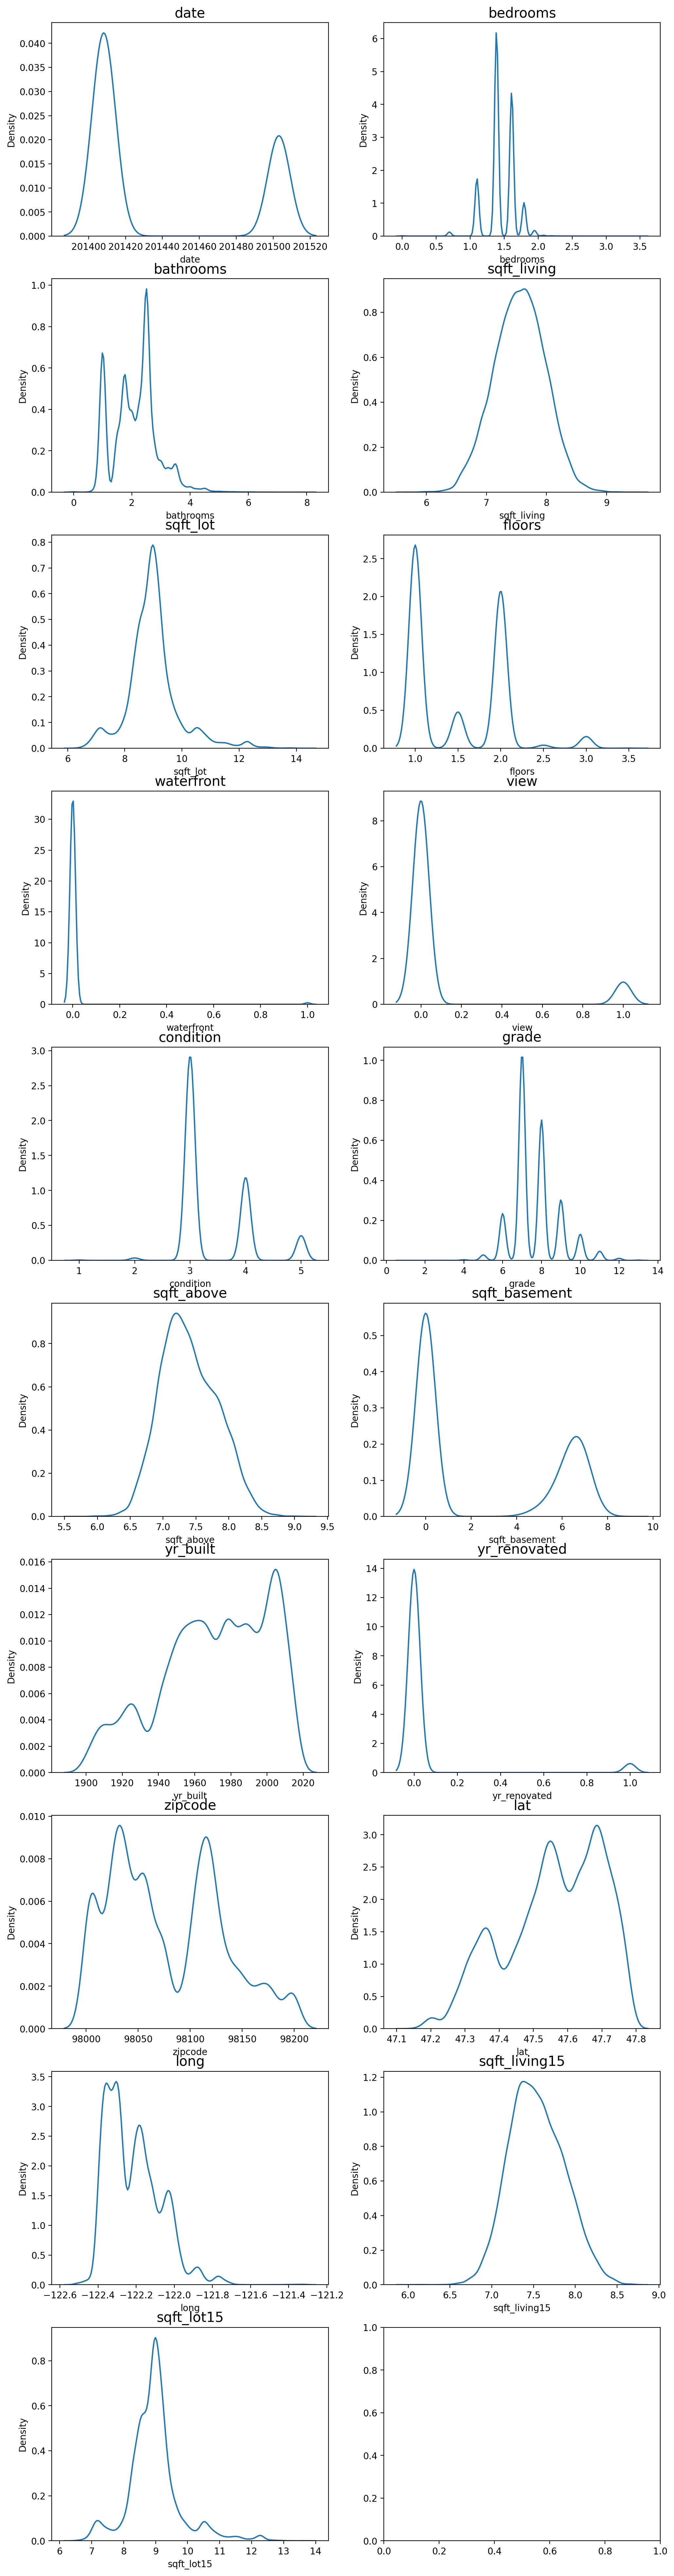

In [20]:
fig, ax = plt.subplots(10, 2, figsize=(12, 50))   

count = 1
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 20:
            break

# 데이터 나누기
- 이상치로 보이는 몇몇 데이터가 있었지만, 최대한 있는 그대로의 데이터를 사용하고자 하였음
- zipcode변수는 단순한 우편주소이고, price와의 선형관계도 없어서 제거하였음

In [21]:
train = data[:train_len]
test = data[train_len:]

print(train.shape)
print(test.shape)

(15035, 20)
(6468, 20)


In [23]:
train = train.drop(labels=['id','date','zipcode'],axis = 1)
test = test.drop(labels=['id','date','zipcode'],axis = 1)

print(train.shape)
print(test.shape)

(15035, 17)
(6468, 17)


In [22]:
#y값 로그 변환 해주기

y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

# 모델 불러오기
## 그리드 서치
- 사람이 하이퍼 파라미터의 값을 정해두고 그 값으로 만들어질 수 있는 모든 조합을 탐색
- 특정 값에대한 하이퍼 파라미터 조합을 탐색하고자 할 때 유리
## 랜덤 탐색
- 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택하는 방법
- 그리드 탐색보다 더 좋은 조합을 탐색할 가능성도 있음
- 인자
-param_grid : 탐색할 파라미터의 종류 (딕셔너리 형태)
- scoring : 모델 성능 평가 지표
- cv : cross validation을 수행하기 위한 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지
- n_jobs : 사용할 CPU 개수

In [24]:
random_state=42 #random_state 고정

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

## gboost
- 이전 트리의 오차를 보완하는 방법 (랜덤 포레스트를 개선한 방법이다!)
- 특징 
 - 강력한 가지치기
 - 트리의 깊이가 깊지 않다.
 - 무작위성이 없다.
 - 매개 변수 조절이 힘들다.
 - 랜덤 포레스트에서는 트리의 수가 가장 중요한 인자이고, 그레이디언트 부스팅은 트리의 수와 학습률 두 가지가 중요한 인자이다. 
 
- n_estimator : 트리의 수 default = 100
- max_depth : 트리의 깊이  default = 3
- Learning rate : 학습률 default = 0.1

In [40]:
gboost_param_grid = {
    'n_estimators': [100,200,300,400,500,600],
    'max_depth': [3,5,10,15,20],
    'learning_rate':[0.05,0.01,0.1],
}

In [26]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [41]:
my_GridSearch(gboost, train, y, gboost_param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


learning_rate  max_depth  n_estimators     score     RMSLE
11           0.05          5           600 -0.028002  0.167338
10           0.05          5           500 -0.028070  0.167542
69           0.10          5           400 -0.028132  0.167727
70           0.10          5           500 -0.028133  0.167730
9            0.05          5           400 -0.028199  0.167925
..            ...        ...           ...       ...       ...
42           0.01         10           100 -0.068852  0.262397
48           0.01         15           100 -0.070166  0.264889
54           0.01         20           100 -0.074842  0.273573
36           0.01          5           100 -0.083551  0.289053
30           0.01          3           100 -0.102403  0.320005

[90 rows x 5 columns]

In [42]:
gboost = GradientBoostingRegressor(n_estimators = 600, max_depth = 5, learning_rate = 0.05, random_state=random_state)

In [30]:
def save_submission(model, train, y, test, model_name, rmsle):
    
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)    
    
    data_dir = 'c:/Users/USER/Desktop/주피터파일/aiffel/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [43]:
save_submission(gboost, train, y, test, 'gboost', rmsle='0.167338')

c:/Users/USER/Desktop/주피터파일/aiffel/data/submission_gboost_RMSLE_0.167338.csv saved!


## xgboost
- 기존 GradientBoosting 알고리즘에 과적합 방지를 위한 기법이 추가된 지도학습 알고리즘
- 특징
 - 장점
  - 과적합 방지가 잘되어 있다
  - 예측 성능이 좋다
 - 단점
  - 작은 데이터에 대하여 과적합 가능성이 있다
  -  해석이 어렵다
- n_estimators[default=100]
- learning_rate[default=0.1]
- min_child_weight[default=1] / child 에서 필요한 모든 관측치에 대한 가중치의 최소합이 값보다 샘플 수가 작으면 leaf node가 된다. 너무 크게 설정하면 Under-fitting 될 수 있음
- max_depth[default=6]
- gamma[default=0] : 트리에서 추가적으로 가지를 나눌지 말지 결정하는 최소 손실 감소 값으로 크게 설정할 수록 과적합이 감소하는 효과가 있음


In [52]:
xgboost_param_grid = {
    'n_estimators': [100,200,300,400,500,600],
    'max_depth': [3,5,10,15,20],
    'learning_rate':[0.05, 0.01,0.1],

}

In [53]:
my_GridSearch(xgboost, train, y, xgboost_param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


learning_rate  max_depth  n_estimators      score     RMSLE
14           0.05         10           300  -0.027108  0.164644
15           0.05         10           400  -0.027192  0.164899
13           0.05         10           200  -0.027281  0.165169
16           0.05         10           500  -0.027314  0.165268
17           0.05         10           600  -0.027379  0.165465
..            ...        ...           ...        ...       ...
42           0.01         10           100 -21.218391  4.606342
36           0.01          5           100 -21.218391  4.606342
54           0.01         20           100 -21.218391  4.606342
48           0.01         15           100 -21.218391  4.606342
30           0.01          3           100 -21.219505  4.606463

[90 rows x 5 columns]

In [34]:
xgboost = XGBRegressor(n_estimators = 300, max_depth = 10, learning_rate = 0.05, random_state=random_state)

In [ ]:
# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(random_state=random_state)
# lightgbm = LGBMRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

In [35]:
save_submission(xgboost, train, y, test, 'xgboost', rmsle='0.164644')

c:/Users/USER/Desktop/주피터파일/aiffel/data/submission_xgboost_RMSLE_0.164644.csv saved!


## lightgbm
- Gradient Boosting Tree 기반 학습 알고리즘
- 특징
 - Light GBM은 Tree가 수직적으로 확장(leaf-wise )
 - 동일한 leaf를 확장할 때, leaf-wise 알고리즘은 level-wise 알고리즘보다 더 많은 loss, 손실을 줄일 수 있음
 - 속도가 빠름
 - 결과의 정확도에 초점을 맞춤
 - 작은 데이터 세트에 사용하는 것은 추천되지 않음
 - 과적합하기 쉽기 때문에 10,000개 이상의 데이터에 사용하는 것이 권장됨
- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_iterations : 반복 수행하려는 트리의 개수를 지정합니다. 너무 크게 설정하면 과적합이 발생 default 100

In [54]:
lightgbm_param_grid = {
    'num_iterations': [100,200,300,400,500,600],
    'max_depth': [3,5,10,15,20],
    'learning_rate':[0.05, 0.01, 0.1]
}

In [55]:
my_GridSearch(lightgbm, train, y, lightgbm_param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


learning_rate  max_depth  num_iterations     score     RMSLE
23           0.05         15             600 -0.027228  0.165010
22           0.05         15             500 -0.027284  0.165177
29           0.05         20             600 -0.027295  0.165211
28           0.05         20             500 -0.027321  0.165291
16           0.05         10             500 -0.027338  0.165342
..            ...        ...             ...       ...       ...
54           0.01         20             100 -0.081101  0.284782
48           0.01         15             100 -0.081101  0.284782
42           0.01         10             100 -0.081103  0.284786
36           0.01          5             100 -0.083707  0.289322
30           0.01          3             100 -0.102394  0.319990

[90 rows x 5 columns]

In [56]:
lightgbm = LGBMRegressor(num_iterations = 600, max_depth = 15, learning_rate = 0.05, random_state=random_state)

In [57]:
save_submission(lightgbm, train, y, test, 'lightgbm', rmsle='0.165010')

c:/Users/USER/Desktop/주피터파일/aiffel/data/submission_lightgbm_RMSLE_0.165010.csv saved!


## rdforest
- 기존 배깅의 이점을 살리고 변수를 랜덤으로 선택하는 과정을 추가함으로써 개별 나무들의 상관성을 줄여 예측력을 향상한 앙상블 모형
- 특징
 - 출력 변수와 입력 변수간 복잡한 관계를 모델링 가능
 - 예측력이 좋음
 - 이상치에 강함
 - 모형 해석이 어려움
 - 다른 앙상블처럼 유연하지 않음
 - 계산량이 많고 학습에 소요되는 시간이 너무 많음
- n_estimators : 결정트리의 갯수를 지정 / Default = 100
- min_samples_split : 노드를 분할하기 위한 최소한의 샘플 데이터 수 / Default = 2
- max_depth : 트리의 최대 깊이 / default = auto
- min_samples_spli : 노드를 분할하기 위한 최소한의 샘플 데이터 수 / Default = 2
- min_samples_leaf : 리프노드가 되기 위한 최소한의 샘플 데이터수(과적합을 제어하는데 사용합니다. 값이 작을수록 과적합 가능성 증가) / default : 1

In [48]:
rdforest_param_grid = {
    'n_estimators': [100,200,250,300,400,500],
    'max_depth': [3,5,10,15],
    'min_samples_leaf' : [3,4,5]
}

In [49]:
my_GridSearch(rdforest, train, y, rdforest_param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


max_depth  min_samples_leaf  n_estimators     score     RMSLE
58         15                 3           400 -0.032875  0.181314
59         15                 3           500 -0.032890  0.181355
57         15                 3           300 -0.032901  0.181387
56         15                 3           250 -0.032945  0.181507
55         15                 3           200 -0.032976  0.181592
..        ...               ...           ...       ...       ...
13          3                 5           200 -0.085583  0.292546
1           3                 3           200 -0.085583  0.292546
12          3                 5           100 -0.085900  0.293086
6           3                 4           100 -0.085900  0.293086
0           3                 3           100 -0.085900  0.293086

[72 rows x 5 columns]

In [50]:
rdforest = LGBMRegressor(n_estimators = 400, max_depth = 15, min_samples_leaf = 3, random_state=random_state)

In [51]:
save_submission(rdforest, train, y, test, 'rdforest', rmsle='0.181314')

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
c:/Users/USER/Desktop/주피터파일/aiffel/data/submission_rdforest_RMSLE_0.181314.csv saved!


# 앙상블 시도

In [76]:
gboost = GradientBoostingRegressor(n_estimators = 600, max_depth = 5, learning_rate = 0.05, random_state=random_state)
lightgbm = LGBMRegressor(num_iterations = 600, max_depth = 15, learning_rate = 0.05, random_state=random_state)
rdforest = LGBMRegressor(n_estimators = 400, max_depth = 15, min_samples_leaf = 3, random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [79]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [80]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8991
Model: XGBoost, CV score:0.9023
Model: LightGBM, CV score:0.9019


In [81]:
def AveragingBlending(models, train, y, test):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [89]:
return_y = np.expm1(y)
return_y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [90]:
y_pred = AveragingBlending(models, train, return_y, test)
print(len(y_pred))
y_pred

6468


array([ 533562.61420457,  467191.13635595, 1452640.00280796, ...,
        468700.30489801,  338873.25171143,  439735.68540936])

In [91]:
data_dir = 'c:/Users/USER/Desktop/주피터파일/aiffel/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [92]:
submission['price'] = y_pred
submission.head()

id         price
0  15035  5.335626e+05
1  15036  4.671911e+05
2  15037  1.452640e+06
3  15038  2.859192e+05
4  15039  3.221862e+05

In [93]:
submission_path = join(data_dir, 'ensenble_submission2.csv')
submission.to_csv(submission_path, index=False)

# 회고
- 예전 프로젝트때와 논문을 쓸때 트리 계열 모델을 다뤄본적이 있었습니다.
- 그 당시에는 lightgbm의 성능이 가장 좋았었는데, 이번에는 xgboost의 성능이 가장 높게 나왔습니다.
- 모델은 데이터에 따라서 성능이 달라진다는 것을 다시 한번 깨달았습니다.
- 배웠던 것을 활용하여, 직접 feature engineering을 시도해보았습니다.
- 다양한 변수가 있었지만, 많은 변수를 활용했다면 성능이 올랐을까라는 
- 그 당시에는 그리드 서치 없이 고정된 파라미터 값을 사용하였는데, 이번에는 그리드 서치를 사용해서 최적 파라미터를 찾아보았습니다.
- 그리드 서치에 대해 공부할 수 있었던 것이 좋았습니다.
- 또한 각 모델별 하이퍼 파라미터가 다양하게 많은데, 확실하게 파악하는것이 어려웠으며, 많이 써보지 못한것이 아쉬웠습니다.
- 앙상블 기법을 다시 한번 공부할 수 있었으며, 코드를 제대로 적용해보았다는것도 learning point가 될 것 같습니다.
- 하지만 앙상블 기법이 가장 좋은 성능을 낸것은 아니었습니다. 
- 이번 프로젝트는 가장 늦게 제출했는데, 처음에 하이퍼 파라미터를 너무 많이 설정해서 모델 자체가 돌아가지 않는 현상이 발생했습니다.
- 아쉽게도 평가 조건을 만족하는 성능을 내지는 못했지만, 저에게 많은 도움이 된 exploration이었습니다.

# 참고
- https://romg2.github.io/mlguide/08_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-05.-%ED%9A%8C%EA%B7%80-%ED%9A%8C%EA%B7%80%EB%B6%84%EC%84%9D/
- https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=youji4ever&logNo=221896163376
- https://velog.io/@highway92/XGBoost-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0%EB%93%A4
- https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
- http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/
- https://creatorjo.tistory.com/143
- https://zephyrus1111.tistory.com/232
- https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
- https://zephyrus1111.tistory.com/249
- https://herjh0405.tistory.com/38
- https://sevillabk.github.io/RandomForest/